### Image processing and inferencing

In [66]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import os
import albumentations as A
import random
import torch
from albumentations.pytorch import ToTensorV2

#### Preprocessing

In [67]:
preprocessing_transform = A.Compose([
    A.LongestMaxSize(max_size=332, interpolation=3),  # Downscale with Lanczos
    A.ImageCompression(quality_lower=90, quality_upper=90, p=1.0),  # JPEG compression
    A.LongestMaxSize(max_size=332, interpolation=3),  # Ensure max dimension
    A.PadIfNeeded(min_height=332, min_width=332, border_mode=0, value=255),  # Pad to square
    A.Resize(height=224, width=224, interpolation=3),  # Resize to 224x224
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalization
    ToTensorV2(),  # Convert to PyTorch tensor
])

/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/168219590.py:3: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=90, quality_upper=90, p=1.0),  # JPEG compression
/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/168219590.py:5: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=332, min_width=332, border_mode=0, value=255),  # Pad to square


In [68]:
def preprocess_image(image):
    return preprocessing_transform(image=image)['image']

#### Noise Injection

In [86]:
def distort_image(image, noise_strength=0):
    """
    Apply Albumentations pipeline with Gaussian noise, Multiplicative noise,
    Distortion, and CoarseDropout. 
    noise_strength = 0 -> return original image
    noise_strength = 1..3 -> increasing noise harshness
    """
    if noise_strength == 0:
        return np.array(image)
    
    image_np = np.array(image)
    
    # Scale augmentation parameters with noise_strength
    
    gaussian_var_limit = (noise_strength*0.05, noise_strength*0.05)
    height = image_np.shape[0]
    dropout_percentage_h_w = min(0.05 * noise_strength, 0.1)
    dropout_h_w_range_val = int(dropout_percentage_h_w * height)
    dropout_h_w_range = [dropout_h_w_range_val, dropout_h_w_range_val]

    # Albumentations transformations
    
    gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)

    # Choose dropout fill value at random
    
    dropout_fill_value = random.choice(["random_uniform", "random"])
    number_of_dropout_areas_range = [noise_strength, noise_strength]

    # print(f"cutout fill value for noise_strength={noise_strength} : {dropout_fill_value}")
    
    dropout = A.CoarseDropout(
        num_holes_range = number_of_dropout_areas_range,
        hole_height_range = dropout_h_w_range,
        hole_width_range = dropout_h_w_range,
        fill=dropout_fill_value,
        p=1
    )

    color_jitter = A.ColorJitter(
        brightness=0.1 * noise_strength,
        contrast=0.1 * noise_strength,
        saturation=0.1 * noise_strength,
        hue=0.08 * noise_strength,
        p=1
    )

    # Albumentations pipeline
    
    transform = A.Compose([
        color_jitter,
        dropout,
        A.LongestMaxSize(max_size=332, interpolation=3),  # Ensure max dimension
        gaussian_noise,
    ])

    # Apply to image
    
    distorted = transform(image=image_np)
    return distorted["image"]


#### Function to distort image + preprocess + display

In [70]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def display_distorted_images(url, pre_process=False):
    """
    Downloads an image from a URL, applies distortions with noise strengths 0..3,
    and displays the results in a grid.

    Args:
        url (str): URL of the image
        pre_process (bool): If True, also applies preprocess_image 
                            before displaying
    """
    # Download image
    response = requests.get(url)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content)).convert("RGB")

    results = []
    for i in range(4):
        distorted = distort_image(image, noise_strength=i)
        if pre_process:
            tensor_img = preprocess_image(distorted)  # torch tensor (C,H,W)
            # Convert tensor back to displayable NumPy image
            img_np = tensor_img.permute(1, 2, 0).cpu().numpy()
            # Undo normalization to bring back [0,1] for matplotlib
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img_np = img_np.clip(0, 1)
            results.append(img_np)
        else:
            results.append(distorted)

    # Display results in grid
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(results[i])
        ax.set_title(f"Noise Strength {i}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


#### Testing noise strength on sample image URLs

cutout fill value for noise_strength=1 : random
cutout fill value for noise_strength=2 : random
cutout fill value for noise_strength=3 : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/2770113277.py:23: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)


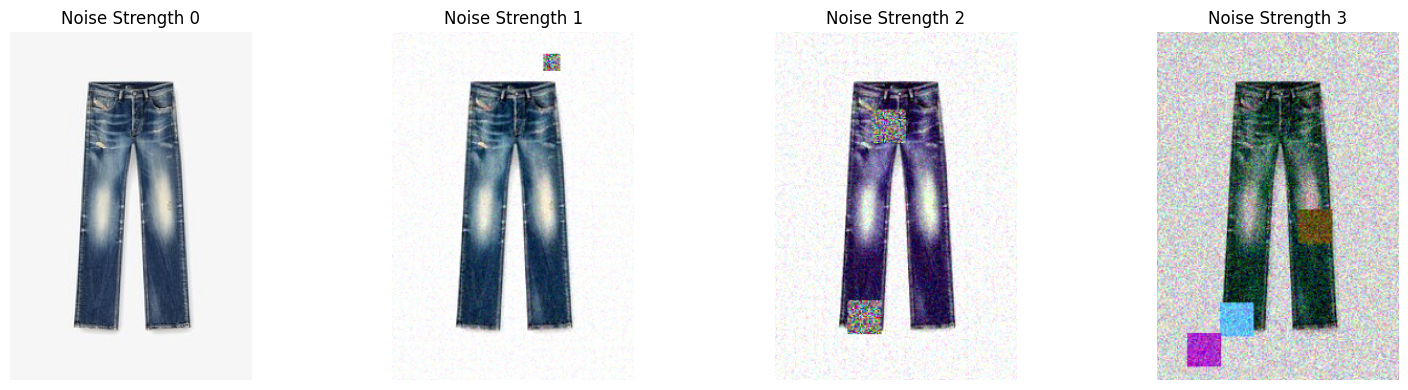

In [72]:
test_url = "https://img01.ztat.net/article/spp-media-p1/0dff5c8b79394f748b0f5f59558d0d2e/7cbaa9bff2ab4ac98a7bea4070ac80b7.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

cutout fill value for noise_strength=1 : random_uniform
cutout fill value for noise_strength=2 : random_uniform
cutout fill value for noise_strength=3 : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/2770113277.py:23: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)


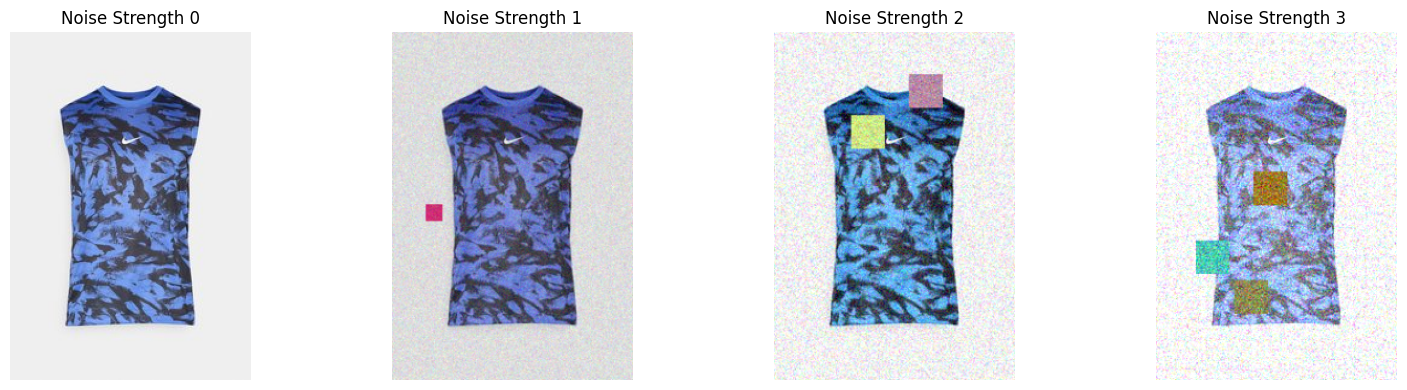

In [74]:
test_url = "https://img01.ztat.net/article/spp-media-p1/21d0fe1b996b442289f5eabde941ede6/70e435a260f3460392e34fff5feb3e8a.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

cutout fill value for noise_strength=1 : random_uniform
cutout fill value for noise_strength=2 : random
cutout fill value for noise_strength=3 : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/2770113277.py:23: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)


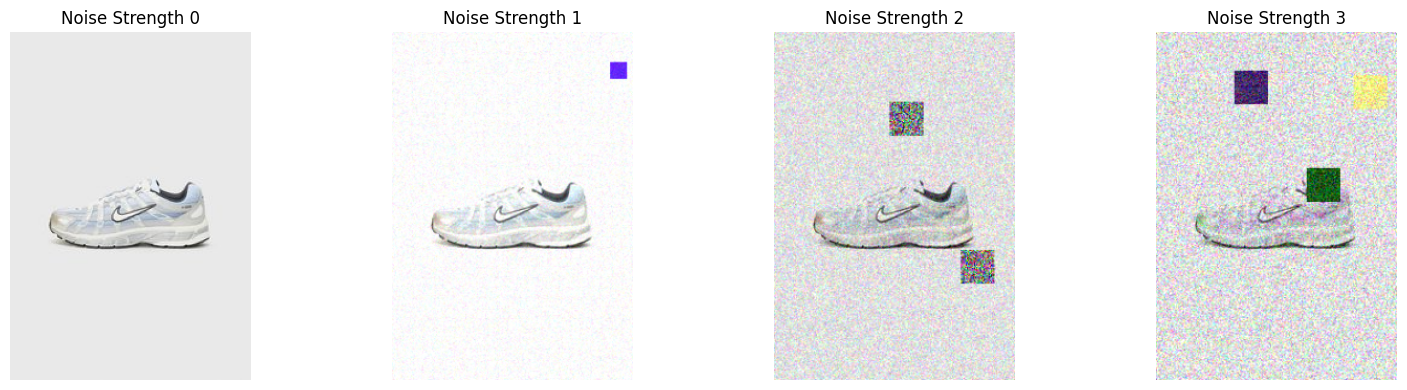

In [75]:
test_url = "https://img01.ztat.net/article/spp-media-p1/77ee1ce7e402424db0c58512165b72ac/b3d0aacaa2204decb31fecda85c54f71.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

#### Noise injection + preprocess together

/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/2770113277.py:23: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)


cutout fill value for noise_strength=1 : random
cutout fill value for noise_strength=2 : random_uniform
cutout fill value for noise_strength=3 : random


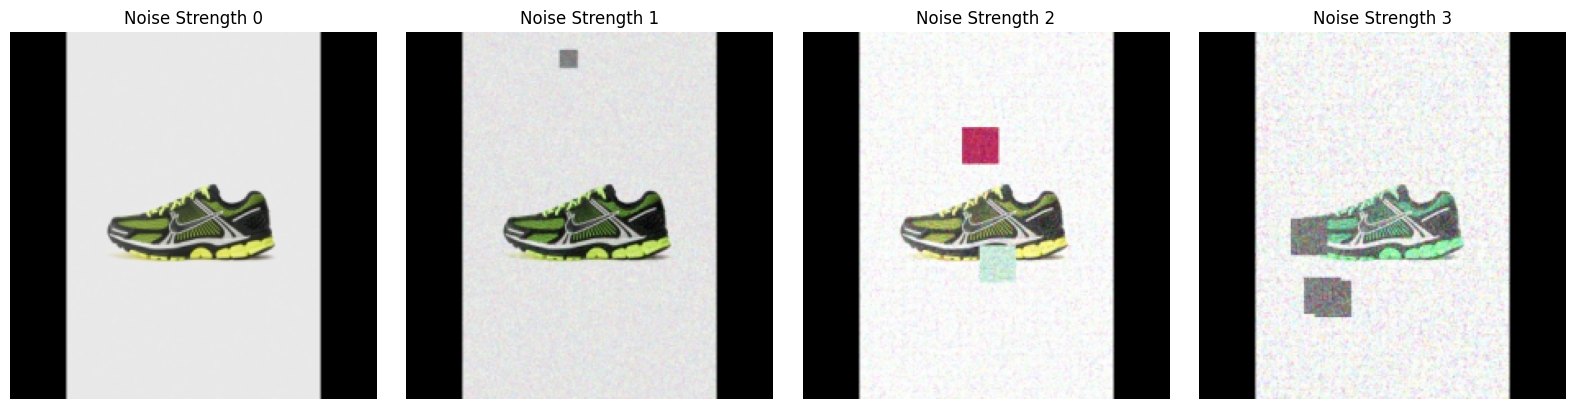

In [79]:
test_url = "https://img01.ztat.net/article/spp-media-p1/8bb716609fba48409ef5ec5674e327ca/22c66a3e34674fca823ee0eb06ecbcc9.jpg?imwidth=1800&filter=packshot"
display_distorted_images(test_url, pre_process=True)

#### Inference using serverless resource from modal.com

In [80]:
IMAGE_FOLDER = "./shoes_mini_dataset" # Folder where the images of garment/shoes are stored
OUTPUT_FOLDER = "./latents" # Folder to save latent space .npy files

In [81]:
def tensor_to_bytes(tensor_img: torch.Tensor, format="PNG") -> bytes:
    """
    Convert a PyTorch tensor [C,H,W] in [0,1] or [0,255] to image bytes.
    """
    # Ensure tensor is on CPU and detached
    tensor_img = tensor_img.detach().cpu()
    
    # Scale 0-1 -> 0-255 if needed
    if tensor_img.max() <= 1.0:
        tensor_img = tensor_img * 255
    tensor_img = tensor_img.to(torch.uint8)
    
    # Convert from [C,H,W] -> [H,W,C] for PIL
    img_np = tensor_img.permute(1, 2, 0).numpy()
    
    # Create PIL image
    pil_img = Image.fromarray(img_np)
    
    # Save to bytes
    buf = io.BytesIO()
    pil_img.save(buf, format=format)
    return buf.getvalue()

In [88]:
from modal_infra.modal_app import run_inference
import io
import time

def run_inference_on_images_and_save_latent_space(image_folder=IMAGE_FOLDER, output_folder=OUTPUT_FOLDER):
    """
    Process images in a folder, apply transformations with different noise strengths,
    run model inference, and save latent spaces as .npy files.
    """
    # Ensure output folder exists
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # For logging time it takes
    start_time = time.time()
    num_calls = 0

    # Loop over all image files in the folder
    for image_path in Path(image_folder).glob("*"):
        if not image_path.is_file():
            continue

        image_name = image_path.name  # filename with extension

        # Read image
        image = Image.open(image_path)

        # Run for 4 different transform strengths
        for noise_strength in range(4):
            # Distort image with given strength
            distorted_image = distort_image(image, noise_strength=noise_strength)
            
            # Then preprocess for model input
            tensor_img = preprocess_image(distorted_image)

            # Convert distorted image tensor to bytes
            img_bytes = tensor_to_bytes(tensor_img)

            # Model inference
            latent_space = run_inference.remote(img_bytes)

            # Save latent space with prefix
            output_path = Path(output_folder) / f"{image_name}_{noise_strength}_latent_space.npy"
            np.save(output_path, latent_space)
            num_calls += 1
    
    elapsed = time.time() - start_time
    print(f"Took {elapsed:.2f} seconds for {num_calls} remote inference calls.")

#### Run inference on modal servers

In [83]:
!modal deploy ./modal_infra/modal_app.py

⠸ Creating objects.....
└── ⠋ Creating mount 
    /Users/cistusai/Desktop/silkroad/PretrainedECommModelsEvaluation/modal_infra
⠦ Creating objects...
└── ⠸ Creating mount 
    /Users/cistusai/Desktop/silkroad/PretrainedECommModelsEvaluation/modal_infra
⠏ Creating objects...
├── 🔨 Created mount 
│   /Users/cistusai/Desktop/silkroad/PretrainedECommModelsEvaluation/modal_infra
│   /modal_app.py
⠏ Creating objects...
├── 🔨 Created mount 
│   /Users/cistusai/Desktop/silkroad/PretrainedECommModelsEvaluation/modal_infra
│   /modal_app.py
└── 🔨 Created function run_inference.
✓ Created objects.
├── 🔨 Created mount 
│   /Users/cistusai/Desktop/silkroad/PretrainedECommModelsEvaluation/modal_infra
│   /modal_app.py
└── 🔨 Created function run_inference.
✓ App deployed in 1.351s! 🎉

View Deployment: 
https://modal.com/apps/onur-2/main/deployed/trendyol-dino-inference


In [90]:
import modal
from modal_infra.modal_app import MODAL_APP_NAME

# replace with the name you gave in inference_app.py
run_inference = modal.Function.from_name(MODAL_APP_NAME, "run_inference")

In [91]:
run_inference_on_images_and_save_latent_space()

/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_29465/1206866851.py:23: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True, noise_scale_factor=0.9, p=1)


Took 301.43 seconds for 676 remote inference calls.


### Latent space explorations - robustness of the model